# Desafio de dados ENEM 2019

## Introdução

Neste documento, realizaremos algumas explorações com os microdados do ENEM de 2019. Nossos objetivos serão:

1. Determinar qual componente (CH, CN, LC, MT) contribui com um crescimento mais rápido da média final.
2. Prever a nota final do estudante a partir de sua nota em MT.

## Carregamento e limpeza dos dados

Iniciaremos importando módulos necessários e definindo construtos auxiliares.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import statsmodels.api as sm

import seaborn as sns

C:\Users\pedro.pompermayer\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\pedro.pompermayer\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
# essa mensagem tá incomodando e não pretendo resolver agora!
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
def calc_media(*notas: list) -> float:
    """
    Retorna a média ponderada dos valores contidos em `notas`,
    utilizando pesos definidos no corpo da função.
    """
    pesos = [1, 3, 1, 3, 2]
    produtos = [nota*peso for nota,peso in zip(notas,pesos)]
    return sum(produtos) / sum(pesos)

In [4]:
class correlacao:
    
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.X = np.array(df[self.x]).reshape((-1, 1))
        self.Y = np.array(df[self.y])
        self.a = 0
        self.b = 0
        self.b_025 = 0
        self.b_975 = 0
        self.a_025 = 0
        self.a_975 = 0
        self.funcao = ''
        
        self.treina()
        self.resultados()

    def treina(self):
        self.modelo = sm.OLS(self.Y, sm.add_constant(self.X)).fit()
        self.b, self.a = self.modelo.params
        (self.b_025, self.b_975), (self.a_025, self.a_975) = self.modelo.conf_int()
        self.funcao = 'y = ' + str(round(self.a, 4)) + ' x + ' + str(round(self.b, 4))
        
    def resultados(self):
        print('Correlação entre', self.x, 'e', self.y)
        print('Função dada por', self.funcao)
        print('Intervalo de coeficiência para coef_ang: [', self.a_025, ';', self.a_975, ']')
        print('Intervalo de coeficiência para coef_lin: [', self.b_025, ';', self.b_975, ']')
        
    def grafico(self):
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.set(
            xlabel=self.x, ylabel=self.y,
            title=f'Correlação entre {self.x} e {self.y}'
        )
        plt.scatter(self.X, self.Y)
        plt.plot(self.X, self.modelo.predict(), color="k")
        plt.text(50, 10, self.funcao, fontsize=16, bbox = dict(facecolor = 'cyan', alpha = 0.5))
        plt.show()

Carregaremos o arquivo `*.csv` contendo os microdados do ENEM 2019, instanciando o *DataFrame* `df`.

In [5]:
dados = pd.read_csv('DADOS/dado_mg.csv', sep=';')

In [6]:
df = dados  # cópia para evitar novas chamadas a `read_csv()`

A partir da análise do dicionário de microdados, verificou-se quais informações serão relevantes para nossa análise, mantendo assim somente essas colunas em `df`.

In [7]:
cols = [
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
    'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 
    'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'TP_LINGUA', 'TP_STATUS_REDACAO',
    'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT'
]
df = df[cols]

Analisaremos os casos em que estudantes estão sem nota. Verificaremos, para cada componente da avaliação, os códigos referentes à presença na prova, sabendo que:

* `0`: Faltou à prova
* `1`: Presente na prova
* `2`: Eliminado na prova

In [8]:
componentes = ['MT', 'CN', 'LC', 'CH']
for componente in componentes:
    prova = 'NU_NOTA_' + componente
    presenca = 'TP_PRESENCA_' + componente
    ft = df.loc[
        df[prova].isnull(), presenca
    ].value_counts()
    print(componente)
    print(ft, end='\n\n')

MT
0    143569
2       203
Name: TP_PRESENCA_MT, dtype: int64

CN
0    143569
2       203
Name: TP_PRESENCA_CN, dtype: int64

LC
0    122985
2       467
Name: TP_PRESENCA_LC, dtype: int64

CH
0    122985
2       467
Name: TP_PRESENCA_CH, dtype: int64



Observa-se, do resultado anterior, que:

* estudantes sem nota **não realizaram** a avaliação, pois possuem códigos de presença `0` ou `2`, apenas;
* os valores retornados para as duplas "MT-CN" e "LC-CH" são correspondentes, uma vez que esses componentes ocorreram nos mesmos dias de avaliação -- um estudante que, por exemplo, não realizou avaliação de MT, certamente também não o fez para CN.

Analisaremos, assim, como nossos dados se comportariam se mantivéssemos valores nulos em nosso dataset, utilizando os resultados de MT.

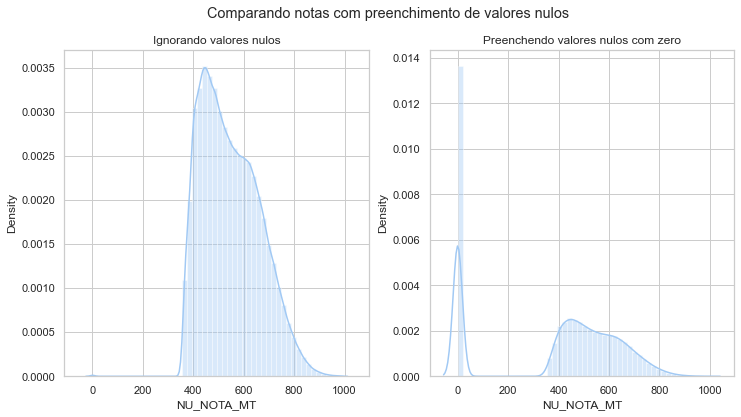

In [9]:
sns.set(style='whitegrid', palette='pastel')
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=False, sharex=True)
fig.suptitle('Comparando notas com preenchimento de valores nulos')

sns.distplot(ax=axes[0], a=df['NU_NOTA_MT'])
axes[0].set_title('Ignorando valores nulos')
sns.distplot(ax=axes[1], a=df['NU_NOTA_MT'].fillna(0))
axes[1].set_title('Preenchendo valores nulos com zero')

plt.show()

Não desejamos preencher nulos com zero, pois entendemos que nota zero possui significado relacionado a desempenho. Consideraremos, então, apenas estudantes que compareceram aos dois dias de prova.

In [10]:
dia1 = df['TP_PRESENCA_LC']==1
dia2 = df['TP_PRESENCA_MT']==1

In [11]:
df = df.loc[(dia1 & dia2), :]

Verifica-se, assim, que não há mais notas nulas:

In [12]:
df.isnull().sum()

NU_NOTA_CN           0
NU_NOTA_CH           0
NU_NOTA_LC           0
NU_NOTA_MT           0
NU_NOTA_COMP1        0
NU_NOTA_COMP2        0
NU_NOTA_COMP3        0
NU_NOTA_COMP4        0
NU_NOTA_COMP5        0
NU_NOTA_REDACAO      0
TP_LINGUA            0
TP_STATUS_REDACAO    0
TP_PRESENCA_CN       0
TP_PRESENCA_CH       0
TP_PRESENCA_LC       0
TP_PRESENCA_MT       0
dtype: int64

Calcularemos a média ponderada de cada estudante, através da função `calc_media()`, armazenando os valores em uma nova coluna `'MEDIA'` no _dataset_.

In [13]:
df.loc[:, 'MEDIA'] = df[[
    'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'NU_NOTA_LC'
]].apply(lambda x: calc_media(*x), axis=1) 

Observaremos a distribuição das notas após essa normalização:

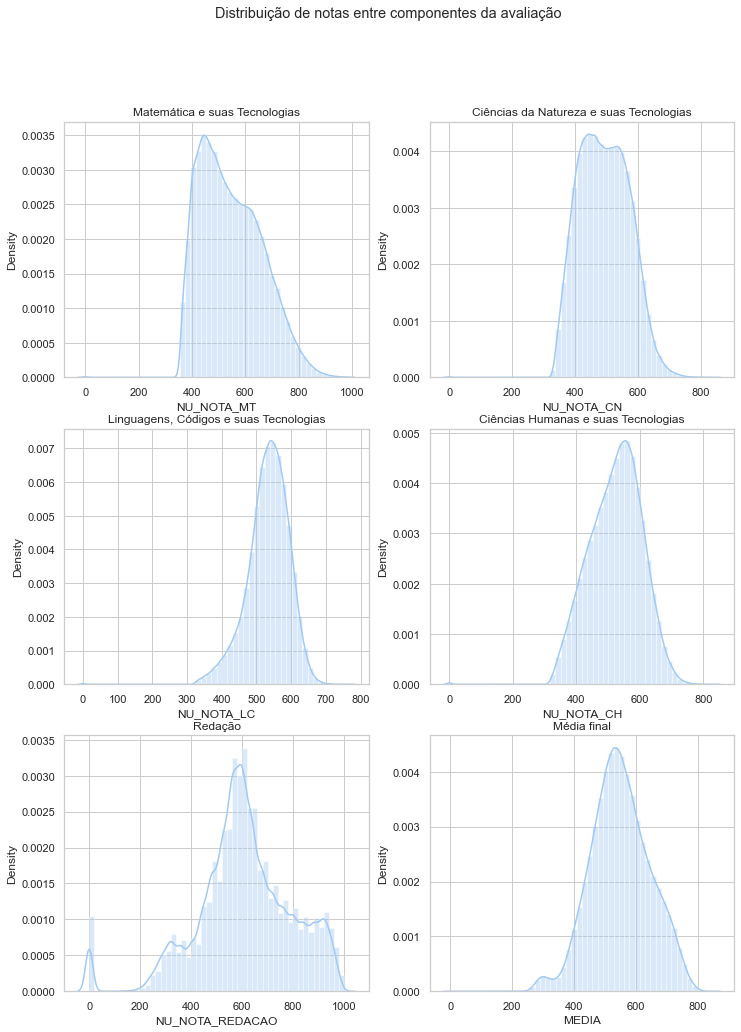

In [14]:
sns.set(style='whitegrid', palette='pastel')
fig, axes = plt.subplots(3, 2, figsize=(12, 16), sharey=False, sharex=False)
fig.suptitle('Distribuição de notas entre componentes da avaliação')

sns.distplot(ax=axes[0, 0], a=df['NU_NOTA_MT'])
axes[0, 0].set_title('Matemática e suas Tecnologias')

sns.distplot(ax=axes[0, 1], a=df['NU_NOTA_CN'])
axes[0, 1].set_title('Ciências da Natureza e suas Tecnologias')

sns.distplot(ax=axes[1, 0], a=df['NU_NOTA_LC'])
axes[1, 0].set_title('Linguagens, Códigos e suas Tecnologias')

sns.distplot(ax=axes[1, 1], a=df['NU_NOTA_CH'])
axes[1, 1].set_title('Ciências Humanas e suas Tecnologias')

sns.distplot(ax=axes[2, 0], a=df['NU_NOTA_REDACAO'])
axes[2, 0].set_title('Redação')

sns.distplot(ax=axes[2, 1], a=df['MEDIA'])
axes[2, 1].set_title('Média final')

plt.show()

---

## Análise dos dados

### 1. Contribuição de cada componente para a nota final

Buscaremos, inicialmente, responder à seguinte pergunta: qual componente curricular (CN, CH, LC e MT) contribui com um crescimento mais rápido da nota final? Para tanto, faremos uma regressão linear entre a nota do componente e a nota final, instanciando objetos da classe `correlação`, definida no início deste documento.

Correlação entre NU_NOTA_MT e MEDIA
Função dada por y = 0.6116 x + 214.8978
Intervalo de coeficiência para coef_ang: [ 0.6098842081393702 ; 0.6133701001470583 ]
Intervalo de coeficiência para coef_lin: [ 213.92343232975992 ; 215.87212303589746 ]


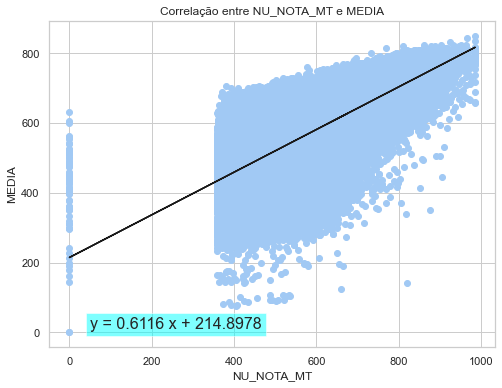

Correlação entre NU_NOTA_LC e MEDIA
Função dada por y = 1.24 x + -111.7599
Intervalo de coeficiência para coef_ang: [ 1.236810286011217 ; 1.243130605360374 ]
Intervalo de coeficiência para coef_lin: [ -113.45565211334474 ; -110.06422667590127 ]


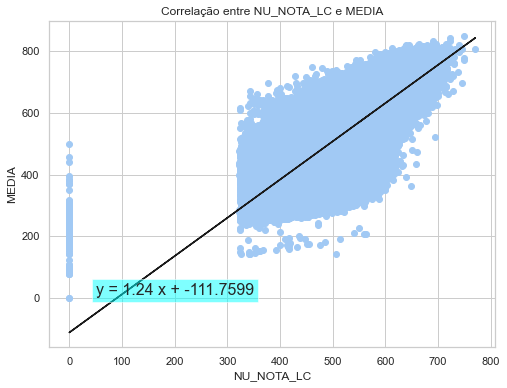

Correlação entre NU_NOTA_CN e MEDIA
Função dada por y = 0.9121 x + 100.2337
Intervalo de coeficiência para coef_ang: [ 0.9095550297591567 ; 0.9146426538542586 ]
Intervalo de coeficiência para coef_lin: [ 98.96512661537705 ; 101.50220326208941 ]


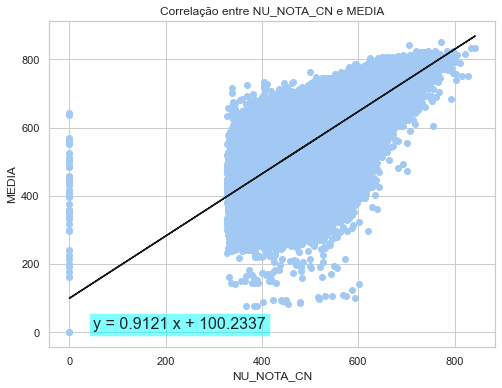

Correlação entre NU_NOTA_CH e MEDIA
Função dada por y = 0.9578 x + 47.7623
Intervalo de coeficiência para coef_ang: [ 0.9557046882778051 ; 0.9598865040890114 ]
Intervalo de coeficiência para coef_lin: [ 46.653800006239635 ; 48.87072732254646 ]


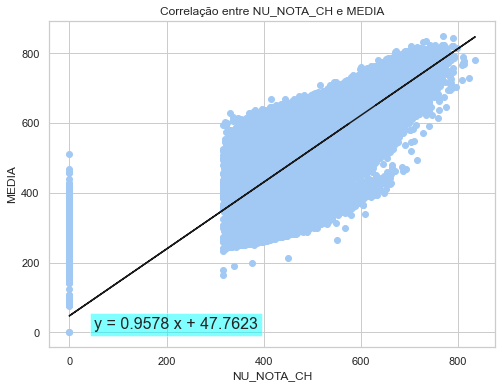

In [15]:
comps = ['NU_NOTA_MT', 'NU_NOTA_LC', 'NU_NOTA_CN', 'NU_NOTA_CH']
for c in comps:
    foo = correlacao(c, 'MEDIA')
    foo.grafico()

Diante do exposto, observa-se que a correlação entre a nota de **linguagens e códigos** e a nota final é a que apresentou maior taxa de crescimento. Em média, um acréscimo de 1 ponto na nota de LC implica num aumento de 1,24 ponto na nota final.

### 2. Predição da nota de matemática a partir da média final

Pretendemos, agora, compreender como a nota de matemática pode ser explicada (prevista) a partir da média final. Para tanto, construiuremos um modelo de regressão linear, utilizando o pacote `scikit-learn`.

Iniciaremos separando `df` em bases de teste e treino, na proporção 4:1 (20% treino e 80% teste):

In [16]:
x = df[['MEDIA']]
y = df['NU_NOTA_MT']

In [17]:
x_treino, x_teste, y_treino, y_teste = train_test_split(
    x, y, test_size=0.2
)

Instanciaremos um objeto `regressao` da classe `LinearRegression()` e realizaremos o treino deste modelo.

In [18]:
regressao = LinearRegression()

In [19]:
regressao.fit(x_treino, y_treino)

LinearRegression()

Com isso, é possível realizar a predição das notas, na base de teste.

In [20]:
y_pred = regressao.predict(x_teste)

Para medir a acurácia de nosso modelo, podemos determinar o erro da predição. Estamos utilizando, do mesmo pacote `scikit-learn`, o **erro médio absoluto** (_mean absolute error_), o **erro quadrático médio** (_mean squared error_) e o **coeficiente de determinação** (_R2 score_).

In [21]:
print('Mean absolute error: %.2f' % mean_absolute_error(y_teste, y_pred))

Mean absolute error: 62.25


In [22]:
print('Mean squared error: %.2f' % mean_squared_error(y_teste, y_pred))

Mean squared error: 5970.25


In [23]:
print('R2 Score: %.2f' % r2_score(y_teste, y_pred))

R2 Score: 0.55


Tais valores certamente poderiam ser melhorados, mas parecem aceitáveis. Um MAE de 63 pontos, num intervalo em que as notas variam de 0 a 1000, indica que o modelo oferece predições significativas.

Plotando num mesmo eixo a distribuição entre as variáveis de teste e a relação entre `x_teste` e `y_pred`, tem-se que:

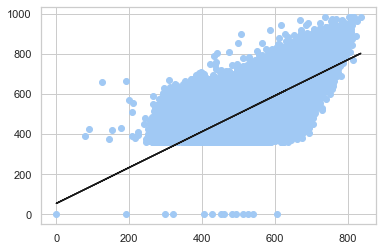

In [24]:
plt.scatter(x_teste, y_teste)
plt.plot(x_teste.to_numpy(), y_pred, color='k')
plt.show()